In [7]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import export_graphviz

from definitions import GEN_PATH, ROOT_DIR

sns.set_context('notebook')
sns.set_style('white')

In [15]:
# Load data and process data set
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])

# Read data
data = pd.read_hdf(proc_match_filepath, key='matches')

# Remove unwanted features and NaNs
drop_cols_first = ['mutual_wins', 'mutual_surface_wins', 'surface', 'home_advantage', 'rel_climate_wins', 'rel_total_wins', 'mutual_games', 'rel_surface_wins']
drop_cols_second = ['outcome', 'tourney_date', 'tourney_level']
data.drop(drop_cols_first, axis=1, inplace=True)
data.dropna(inplace=True)

# Split data set into train and test
# Start of 2019 season in unix time, 2018-12-31 00:00:00 UTC
test_date_begin = 1546214400

# Testing will be done on 2019 matches
data_train = data.loc[data.tourney_date < test_date_begin]
data_train.reset_index(inplace=True)
y_train = data_train.outcome
X_train = data_train.drop(drop_cols_second, axis=1)

display(X_train)

data_test = data.loc[data.tourney_date >= test_date_begin]
data_test.reset_index(inplace=True)
y_test = data_test.outcome
tourney_level_test = data_test.tourney_level

level_map = config['tourney_levels']
points_map = config['match_points']

# Extract number prediction points from match
def get_points(level):
    for key, value in level_map.items():
        if value == level:
            return points_map[key]

tourney_level_test = tourney_level_test.apply(get_points, convert_dtype=True)

X_test = data_test.drop(drop_cols_second, axis=1)

# Number of folds to use in cross-validation
cvs = 5

,index,rank_diff,points_grad_diff,rel_recent_wins,rel_tourney_games,age_diff,player_1,player_2
0,0,0.298397,-0.156014,1.148764,0.000408,-1.069315,105815.0,111581.0
1,1,-0.083118,0.449323,-1.409212,0.000408,0.000917,104269.0,104291.0
2,2,-0.012353,0.015972,0.240009,0.000408,2.141381,126094.0,104500.0
3,3,0.070719,-0.057156,-1.139951,0.000408,1.071149,104735.0,106093.0
4,5,0.143022,-0.057156,2.259463,0.000408,1.308384,105091.0,111506.0
...,...,...,...,...,...,...,...,...
91430,91603,-0.738462,0.028160,0.004406,0.000408,1.028340,122606.0,202356.0
91431,91604,-0.576933,0.085037,0.744873,0.000408,-0.755380,106321.0,144972.0
91432,91605,2.625945,-0.181744,-1.745787,0.000408,-0.548469,106388.0,105897.0
91433,91606,0.241478,-0.063927,-2.082363,0.000408,-0.270208,126239.0,144696.0


              precision    recall  f1-score   support

        -1.0       0.92      0.93      0.92     15101
         1.0       0.93      0.92      0.92     15073

    accuracy                           0.92     30174
   macro avg       0.92      0.92      0.92     30174
weighted avg       0.92      0.92      0.92     30174



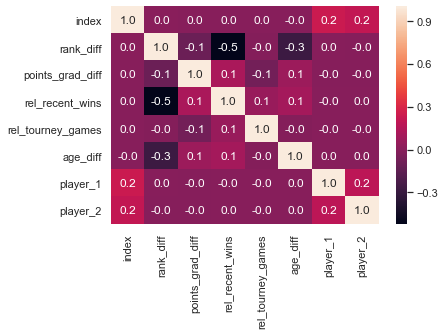

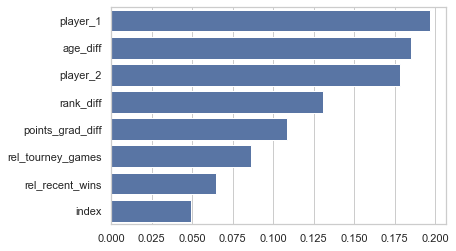

In [16]:
# Run base model static split, RandomForest
Xv_train, Xv_val, yv_train, yv_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

model = RandomForestClassifier()
model.fit(Xv_train, yv_train)

full_val_pred = model.predict(Xv_val)
class_report_full = classification_report(yv_val, full_val_pred)
print(class_report_full)

sns.heatmap(Xv_train.corr(), annot=True, fmt='.1f')
plt.show()

sns.set(style="whitegrid")
feat_imp = pd.Series(model.feature_importances_, index=Xv_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)
sns.barplot(x=feat_imp.to_list(), y=feat_imp.index, color='b')
plt.show()

In [40]:
# Evaluate Random Forest with CV
rf_model = RandomForestClassifier()
scores = cross_val_score(rf_model, X_train, y_train, cv=cvs)
print("RandomForest accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RandomForest accuracy: 0.92 (+/- 0.01)


In [45]:
# Evaluate kNN with CV

k = len(X_train) ** 0.5
knn_model = KNeighborsClassifier()
scores = cross_val_score(knn_model, X_train, y_train, cv=cvs)
print("kNN accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

kNN accuracy: 0.51 (+/- 0.00)


In [ ]:
# Evaluate SVM with CV
# DID NOT FINISH WITHIN REASONABLE TIME

C = 1
kernel = 'rbf'
svm_model = SVC(C, kernel)
scores = cross_val_score(svm_model, X_train, y_train, cv=cvs)
print("SVM accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [5]:
# Evaluate neural network with CV
hidden_layer_sizes = (100,)
activation = 'relu'
alpha = 0.0001
nn_model = MLPClassifier(hidden_layer_sizes, activation, alpha=alpha)
scores = cross_val_score(nn_model, X_train, y_train, cv=cvs)
print("Neural Network accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: C

Neural Network accuracy: 0.71 (+/- 0.20)


In [3]:
# Evaluate chosen model on test data and get score

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
p_test = rf_model.predict(X_test)

print(classification_report(y_test, p_test))

              precision    recall  f1-score   support

        -1.0       0.91      0.92      0.92     13522
         1.0       0.92      0.91      0.92     13457

    accuracy                           0.92     26979
   macro avg       0.92      0.92      0.92     26979
weighted avg       0.92      0.92      0.92     26979



In [37]:
# Display points

df_p = pd.DataFrame(p_test, columns=['prediction'])
c_test = pd.concat([df_p, y_test, tourney_level_test], axis=1)

points = int(round(c_test.tourney_level[c_test.outcome == c_test.prediction].sum()))

print("ML accuracy 2019: %0.2f" % accuracy_score(y_test, p_test))
print("Total points ML 2019:", points)
print("Total best points human 2019:", 19718)

ML accuracy 2019: 0.92
Total points ML 2019: 59069
Total best points human 2019: 19718


In [11]:
# Choose one of the RF estimators and export to a tree

# Extract sample estimator
estimator = rf_model.estimators_[5]

# Export sample tree
tree_out_path = os.path.join(ROOT_DIR, 'output/tree.dot')

export_graphviz(estimator, out_file=tree_out_path, 
                feature_names = X_test.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)